In [1]:
import time

import tensorflow as tf
from tensorflow.contrib import rnn

import numpy as np
from sklearn.metrics import r2_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 16)

print("Package is ready.")

Package is ready.


In [2]:
# Load them!
l = np.load("./Data/ECtrainset_wRWEC.npz")

# See what's in here
print (l.files)

# get data
train_data = l['traindataset']
train_label = l['trainlabel']
test_data = l['testdataset']
test_label = l['testlabel']

mins = l['mins']
maxs = l['maxs']

labelmins = l['labelmins']
labelmaxs = l['labelmaxs']

explanation = "RWEC_multi_GRU"
DELETE = [4,5,11,12]
EX_PRED = 0.668198 #Sorry, it's not automated yet.

train_data = np.delete(train_data, DELETE, axis=1)
test_data = np.delete(test_data, DELETE, axis=1)
train_label = train_label[:,:]
test_label = test_label[:,:]

print(train_data[:5])
print(train_label[:5])
print(test_data[:5])
print(test_label[:5])

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

['maxs', 'trainlabel', 'testdataset', 'mins', 'labelmaxs', 'labelmins', 'traindataset', 'testlabel']
[[ 0.32567992  0.50084235  0.20491604  0.48089765  0.92516063  0.78223629
   0.55528701  0.42583577  0.06756757  0.1855959   0.48086426  0.36363636
   0.52895695  0.14888828  0.23222229  0.24793388]
 [ 0.33018636  0.48709495  0.25655674  0.26491767  0.92931601  0.82019292
   0.45507889  0.35457283  0.06756757  0.23956612  0.26476511  0.36363636
   0.58277116  0.07926687  0.23222229  0.30664601]
 [ 0.32754387  0.39184369  0.24740103  0.480947    0.904194    0.83032818
   0.55135952  0.43005518  0.06756757  0.2554854   0.48090275  0.36363636
   0.64832338  0.03440592  0.23222229  0.30991736]
 [ 0.32294789  0.37715523  0.25419894  0.49524414  0.89576271  0.80197632
   0.55135952  0.43005518  0.06756757  0.2554854   0.49513653  0.36363636
   0.68042326  0.          0.23222229  0.30991736]
 [ 0.32487844  0.37766854  0.2574289   0.51254409  0.90079292  0.7841957
   0.55135952  0.43005518  0.0

In [3]:
#Data setting
n_train = train_label.shape[0]
n_test = test_label.shape[0]
n_input = train_data.shape[1]
n_output = test_label.shape[1]
n_classes = n_output

print("# train: %d # test: %d, # input: %d, # output: %d" % (n_train, n_test, n_input, n_output))


# train: 1200 # test: 456, # input: 16, # output: 18


In [4]:
# Parameters
learning_rate = 0.001
training_epochs = 10000
batch_size = n_train
display_step = 500

# Network Parameters
n_steps = 30 # 1.5 day
n_hidden = 64 # hidden layer num of features
n_layers = 4

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_output])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_output]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_output]))
}

print("parameters are ready")

parameters are ready


In [5]:
# Load them!
l = np.load("./Data/ECpredset_wRWEC.npz")

# See what's in here
print (l.files)

# get data
pred_data = l['preddataset']
pred_label = l['predlabel']
n_pred = pred_label.shape[0]

print(pred_data[0])
print(pred_label[0])

print(pred_data.shape)
print(pred_label.shape)

#Processing

for i in range(pred_data.shape[1]):
    temp = pred_data[:,i]
    temp = (temp - mins[i]) / (maxs[i] - mins[i])
    pred_data[:,i] = temp

    
for i in range(pred_label.shape[1]):
    temp = pred_label[:,i]
    temp = (temp - labelmins[i]) / (labelmaxs[i] - labelmins[i])
    pred_label[:,i] = temp
    
pred_data = np.delete(pred_data, DELETE, axis=1)

pred_x = pred_data.reshape((-1, n_steps, n_input))

['predlabel', 'preddataset']
[   4.509825      2.36598889    3.63195556   16.15047222   19.63758333
   13.21697222   67.13763889    4.470975      1.768         1.382         0.
    6.36231111    4.28258333    5.374425      5.23260278  150.
  408.34777778    0.           30.           12.355     ]
[ 4.48515278  4.46378611  4.44831667  4.42421667  4.40596667  4.37809167
  4.58665556  4.85048889  4.90490833  4.97277778  4.90884722  4.83730833
  4.75139167  4.71204167  4.66605556  4.62548056  4.5976      4.554325  ]
(3600, 20)
(120, 18)


In [6]:
def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)

    # Define a lstm cell with tensorflow
    
    lstm_cells = rnn.MultiRNNCell([rnn.GRUCell(n_hidden) for _ in range(n_layers)])
    
    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cells, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)

print("network is ready")

network is ready


In [7]:
# Define loss and optimizer
cost = tf.multiply(tf.reduce_sum(tf.square(tf.subtract(pred, y))),1/batch_size)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
ymean = tf.reduce_mean(y)
SSE = tf.reduce_sum(tf.square(tf.subtract(y, pred)))
SSR = tf.reduce_sum(tf.square(tf.subtract(pred, ymean)))
r_squared = SSR/(SSE+SSR)
                                
accuracy = r_squared
# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Do some optimizations
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
sess.run(init)

print("seesion start")

seesion start


In [8]:
# Summary writer
tf.summary.scalar('RMS', cost)
tf.summary.scalar('accuracy', accuracy)
merged = tf.summary.merge_all()
directory_name = "./tb_logs/" + explanation + str(n_hidden)
summary_writer = tf.summary.FileWriter(directory_name, graph=sess.graph)
print ("Summary ready")

Summary ready


In [9]:
# Launch the graph
num_data = train_data.shape[0]
ex_pred_acc = EX_PRED

# Keep training until reach max iterations
start = time.time()

for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(num_data/batch_size/n_steps)

    for i in range(total_batch):
        batch_x = train_data[i:i+n_steps*batch_size, :]
        batch_y = train_label[i:i+batch_size, :]
        
        # Reshape data
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_x, y: batch_y})
        avg_cost += sess.run(cost, feed_dict={x: batch_x, y: batch_y})/total_batch
        summary_writer.add_summary(summary, epoch*total_batch+i)
        
        pred_acc = sess.run(accuracy, feed_dict={x: pred_x, y: pred_label})

    if pred_acc > ex_pred_acc:
        bestpath = "./models/best_trained_" + explanation + ".ckpt"
        save_path = saver.save(sess, bestpath)
        ex_pred_acc = pred_acc
        
    if epoch % display_step == 0:
        print ("Epoch: %04d/%04d cost: %.6f, best: %.3f" % (epoch, training_epochs, avg_cost,ex_pred_acc))
        train_acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})

        test_x = test_data.reshape((-1, n_steps, n_input))
        test_acc = sess.run(accuracy, feed_dict={x: test_x, y: test_label})
        pred_acc = sess.run(accuracy, feed_dict={x: pred_x, y: pred_label})
        print ("Training Acc: %.3f, Validation Acc: %.3f, Test Acc: %.3f" % (train_acc, test_acc, pred_acc))
        
            
print ("Epoch: %04d/%04d cost: %.6f" % (epoch+1, training_epochs, avg_cost))
train_acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})

test_x = test_data.reshape((-1, n_steps, n_input))
test_acc = sess.run(accuracy, feed_dict={x: test_x, y: test_label})
print ("Training Acc: %.3f, Validation Acc: %.3f, Test Acc: %.3f" % (train_acc, test_acc, pred_acc))

end = time.time() - start
print ("Optimization Finished\ntraining time: %.2f sec." % (end))

Epoch: 0000/10000 cost: 21.809603, best: 0.668
Training Acc: 0.490, Validation Acc: 0.489, Test Acc: 0.498
Epoch: 0500/10000 cost: 0.112700, best: 0.668
Training Acc: 0.839, Validation Acc: 0.847, Test Acc: 0.510
Epoch: 1000/10000 cost: 0.085983, best: 0.668
Training Acc: 0.875, Validation Acc: 0.877, Test Acc: 0.582
Epoch: 1500/10000 cost: 0.061491, best: 0.668
Training Acc: 0.911, Validation Acc: 0.906, Test Acc: 0.629
Epoch: 2000/10000 cost: 0.059107, best: 0.668
Training Acc: 0.916, Validation Acc: 0.910, Test Acc: 0.644
Epoch: 2500/10000 cost: 0.039296, best: 0.668
Training Acc: 0.943, Validation Acc: 0.933, Test Acc: 0.652
Epoch: 3000/10000 cost: 0.032848, best: 0.668
Training Acc: 0.953, Validation Acc: 0.942, Test Acc: 0.643
Epoch: 3500/10000 cost: 0.027216, best: 0.668
Training Acc: 0.961, Validation Acc: 0.950, Test Acc: 0.634
Epoch: 4000/10000 cost: 0.025135, best: 0.668
Training Acc: 0.964, Validation Acc: 0.955, Test Acc: 0.611
Epoch: 4500/10000 cost: 0.019077, best: 0.668

In [10]:
#Choose best model
saver.restore(sess, bestpath)
print("Model restored, best Acc: %.3f" % ex_pred_acc)

INFO:tensorflow:Restoring parameters from ./models/best_trained_RWEC_multi_GRU.ckpt
Model restored, best Acc: 0.673


In [11]:
#Calculate accuracy for 128 mnist test images
print ("Testing Accuracy:", sess.run(accuracy, feed_dict={x: pred_x, y: pred_label}))

Testing Accuracy: 0.672875


In [12]:
estimation = sess.run(pred, feed_dict={x: test_x, y: test_label})
estimation.shape

(456, 18)

In [13]:
#Data restoring
for i in range(n_output):
    estimation[:,i] = (labelmaxs[i] - labelmins[i]) * estimation[:,i] + labelmins[i]
    test_label[:,i] = (labelmaxs[i] - labelmins[i]) * test_label[:,i] + labelmins[i]

print(estimation[:5])
print(test_label[:5])

[[ 3.6158483   3.66747093  3.70231581  3.74916267  3.78167462  3.79547834
   3.77712846  3.79542708  3.83766961  3.77572703  3.77531099  3.777071
   3.6871593   3.76778102  3.73516464  3.72402477  3.70990753  3.66231132]
 [ 4.41013861  4.42437267  4.36416149  4.35901308  4.37755537  4.34239101
   4.30058193  4.2642107   4.28299046  4.2203207   4.29065418  4.32650518
   4.35181713  4.54525757  4.59115601  4.69252682  4.72741318  4.7754631 ]
 [ 3.76479793  3.76028156  3.77783012  3.79312897  3.75460553  3.69888926
   3.69086266  3.71223927  3.71137977  3.64910984  3.67647982  3.64100718
   3.54554152  3.60046434  3.53955984  3.52023315  3.55313611  3.62800336]
 [ 3.75489497  3.77044201  3.67278361  3.66776466  3.67618704  3.67725635
   3.75024819  3.84891915  3.97478271  3.9638567   4.00529146  4.06690407
   3.99488163  3.9691143   3.92451429  3.86003017  3.90707588  3.82236505]
 [ 3.84655285  3.8572073   3.88304305  3.87376738  3.87414837  3.84594345
   3.83554721  3.83102036  3.7925260

In [14]:
valid_RMSE = np.sum(np.sqrt((test_label - estimation)**2))/(estimation.shape[0]*18)

print("valid RMSE: %.5f" % valid_RMSE)

valid RMSE: 0.07472


In [15]:
for i in range(test_label.shape[1]):
    print(i+1, r2_score(test_label[:, i], estimation[:, i]))

1 0.916307381082
2 0.908492586553
3 0.91256378352
4 0.919317387628
5 0.925107276395
6 0.894217402501
7 0.906762460487
8 0.942872510745
9 0.952940632961
10 0.920101435887
11 0.9309075369
12 0.932398877786
13 0.901931999634
14 0.9411808624
15 0.935477532872
16 0.939424964566
17 0.94526812152
18 0.945705981047


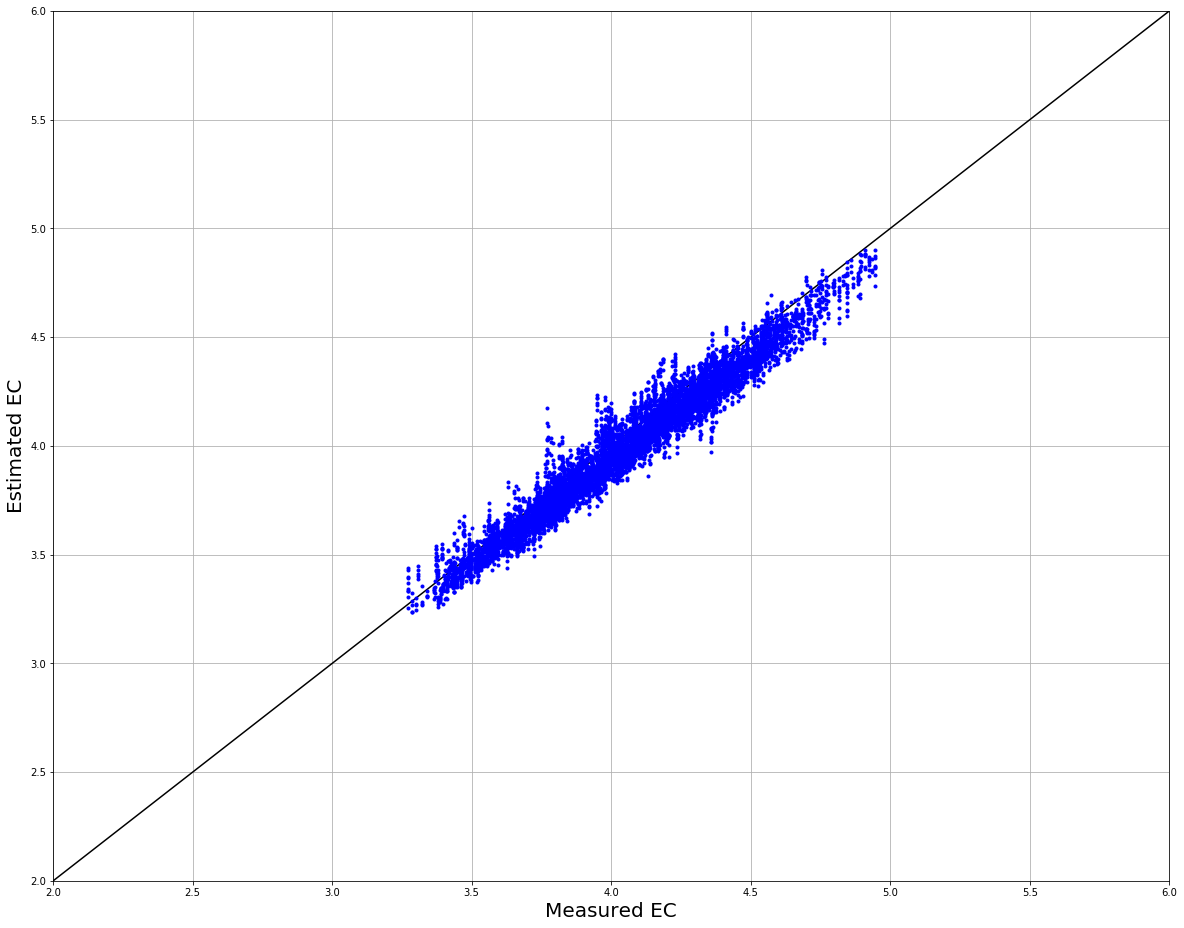

In [16]:
#1:1 graph
x_t = np.arange(-5, 10)
y_t = x_t

xny = plt.plot(x_t,y_t,'k')

expect1 = plt.plot(test_label, estimation, 'b.')

plt.axis([2, 6, 2, 6])
plt.grid(True)
plt.xlabel('Measured EC', {'fontsize':20})
plt.ylabel('Estimated EC',  {'fontsize':20})
#plt.legend([expect1], ["Mg"], prop={'size': 12})
plt.show()

In [17]:
regression_output = np.concatenate((test_label.T, estimation.T), axis=0).T

file_name = "regression_output_" + explanation + ".CSV"
np.savetxt("./Results/" + file_name, regression_output, delimiter=",")

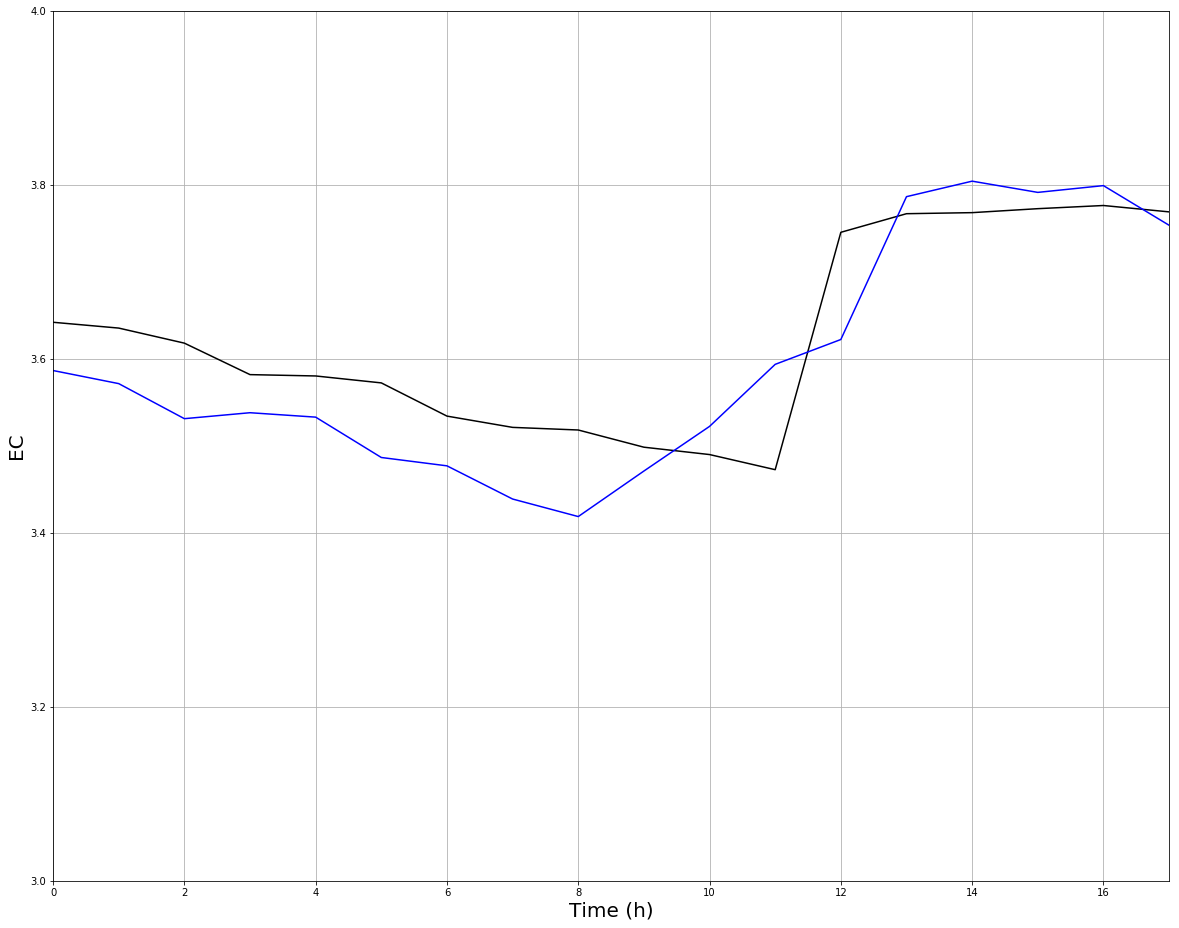

In [18]:
#chronological graph
x_t = np.arange(0, n_output)

measured1 = plt.plot(x_t, test_label[55,:].T, 'k') #estimated

expect1 = plt.plot(x_t, estimation[55,:].T, 'b') #estimated



plt.axis([0, n_output-1, 3, 4])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

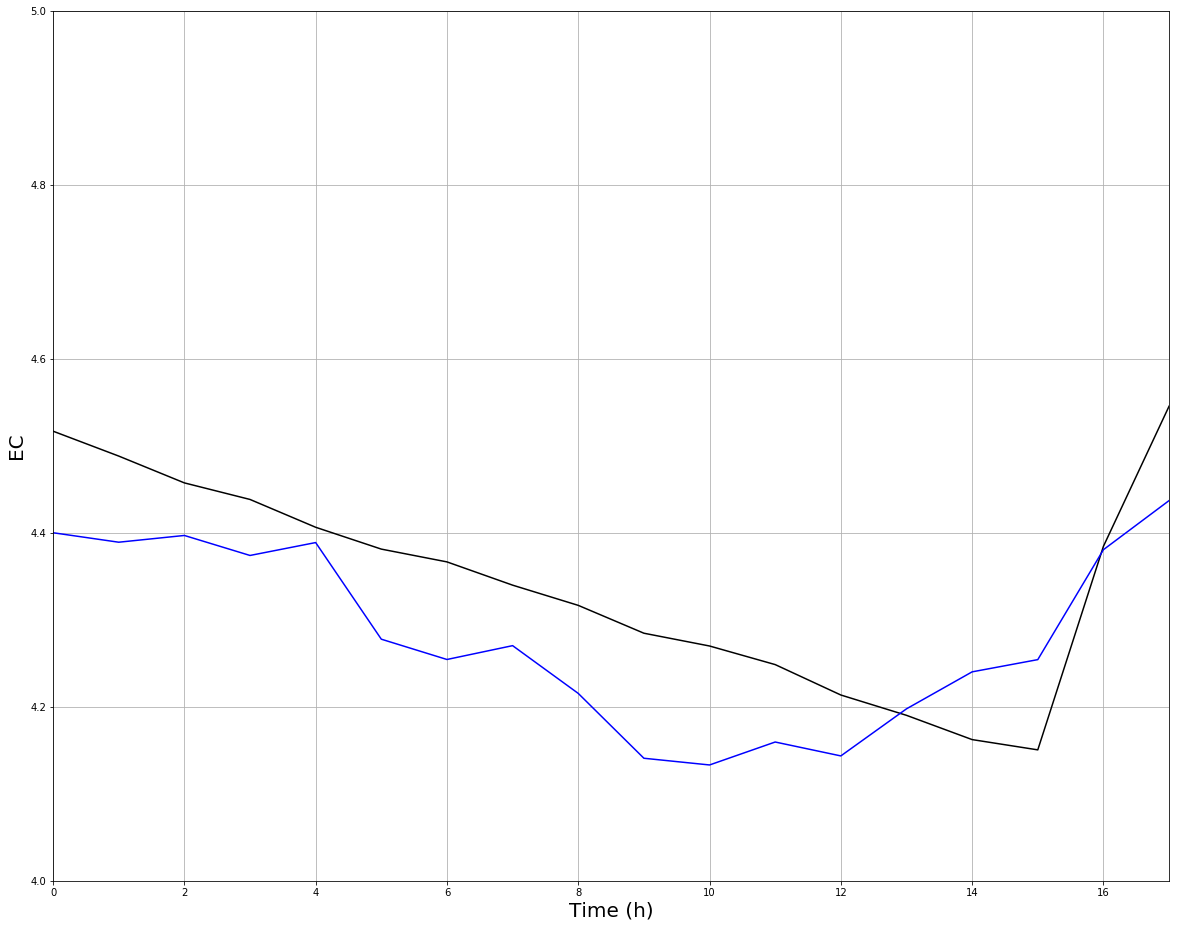

In [19]:
#chronological graph
i = 72
x_t = np.arange(0, n_output)

measured1 = plt.plot(x_t, test_label[i,:].T, 'k') #estimated

expect1 = plt.plot(x_t, estimation[i,:].T, 'b') #estimated



plt.axis([0, n_output-1, 4, 5])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

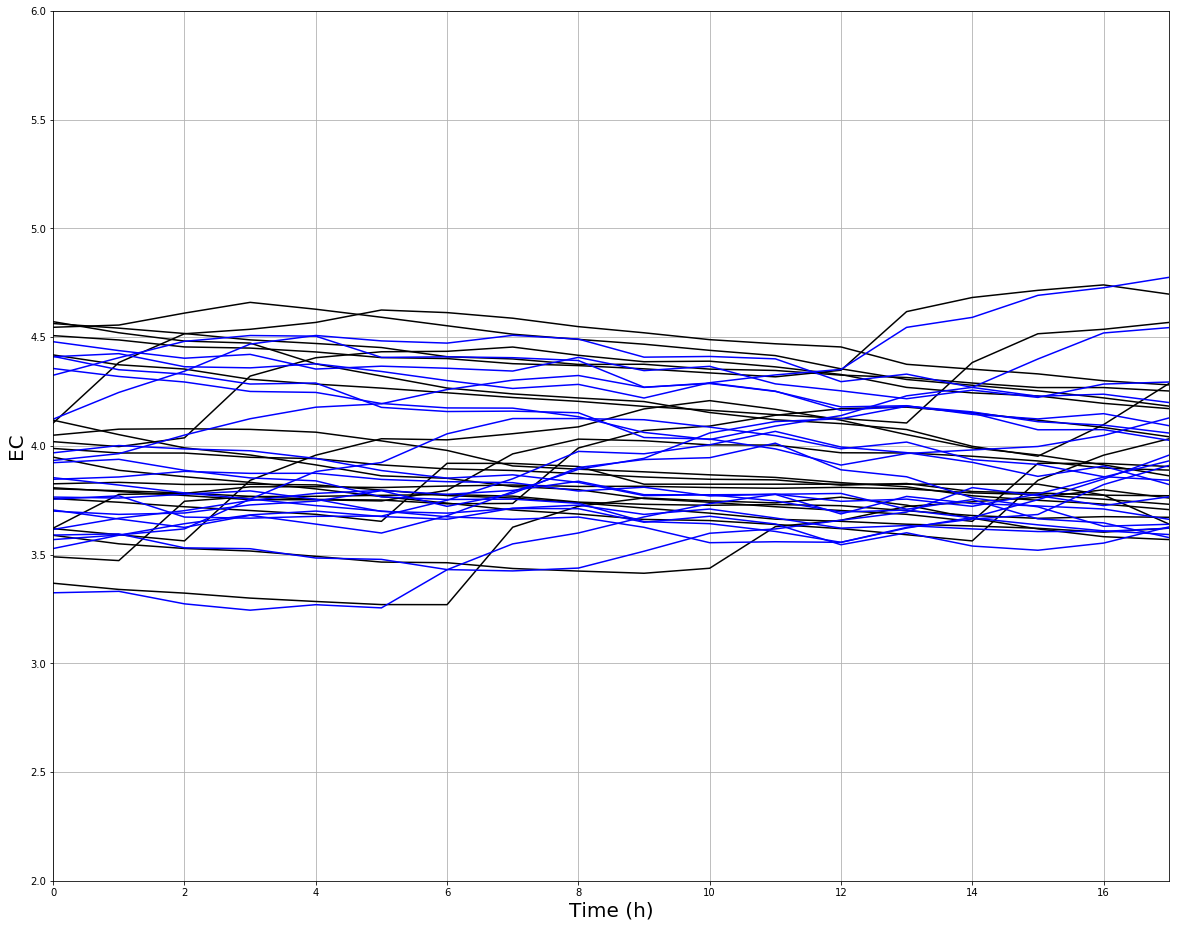

In [20]:
#chronological graph
x_t = np.arange(0, n_output)

measured1 = plt.plot(x_t, test_label[:20,:].T, 'k') #estimated
expect1 = plt.plot(x_t, estimation[:20,:].T, 'b') #estimated

plt.axis([0, n_output-1, 2, 6])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

In [21]:
# Load them!
l = np.load("./Data/ECpredset_wRWEC.npz")

# See what's in here
print (l.files)

# get data
pred_data = l['preddataset']
pred_label = l['predlabel']
n_pred = pred_label.shape[0]

print(pred_data[0])
print(pred_label[0])

print(pred_data.shape)
print(pred_label.shape)

['predlabel', 'preddataset']
[   4.509825      2.36598889    3.63195556   16.15047222   19.63758333
   13.21697222   67.13763889    4.470975      1.768         1.382         0.
    6.36231111    4.28258333    5.374425      5.23260278  150.
  408.34777778    0.           30.           12.355     ]
[ 4.48515278  4.46378611  4.44831667  4.42421667  4.40596667  4.37809167
  4.58665556  4.85048889  4.90490833  4.97277778  4.90884722  4.83730833
  4.75139167  4.71204167  4.66605556  4.62548056  4.5976      4.554325  ]
(3600, 20)
(120, 18)


In [22]:
#Processing

for i in range(pred_data.shape[1]):
    temp = pred_data[:,i]
    temp = (temp - mins[i]) / (maxs[i] - mins[i])
    pred_data[:,i] = temp

    
for i in range(pred_label.shape[1]):
    temp = pred_label[:,i]
    temp = (temp - labelmins[i]) / (labelmaxs[i] - labelmins[i])
    pred_label[:,i] = temp

In [23]:
pred_data = np.delete(pred_data, DELETE, axis=1)

In [24]:
print(pred_data[0])
print(pred_label[0])

[ 0.39660363  0.37346666  0.20244891  0.53094022  0.83060659  0.71674836
  0.53413897  0.44855566  0.06756757  0.21209254  0.53081761  0.36363636
  0.71393845  0.          0.23222229  0.24311295]
[ 0.72520933  0.7124582   0.70322641  0.68884409  0.67795292  0.66131778
  0.78578379  0.9432333   0.97570954  1.01621243  0.97806018  0.93536746
  0.88409442  0.86061126  0.83316784  0.80895364  0.79231518  0.76648968]


In [25]:
pred_label.shape

(120, 18)

In [26]:
pred_x = pred_data.reshape((-1, n_steps, n_input))

print ("Prediction Accuracy:", sess.run(accuracy, feed_dict={x: pred_x, y: pred_label}))
prediction = sess.run(pred, feed_dict={x: pred_x, y: pred_label})

Prediction Accuracy: 0.672875


In [27]:
#Data restoring
for i in range(n_output):
    prediction[:,i] = (labelmaxs[i] - labelmins[i]) * prediction[:,i] + labelmins[i]
    pred_label[:,i] = (labelmaxs[i] - labelmins[i]) * pred_label[:,i] + labelmins[i]

print(prediction[0])
print(pred_label[0])

[ 4.40018225  4.38433933  4.3520565   4.40930271  4.40291214  4.39590216
  4.57011652  4.70794678  4.85680342  4.83477497  4.84105778  4.87411404
  4.8361783   4.84814358  4.78037643  4.75571918  4.68627071  4.61787367]
[ 4.48515278  4.46378611  4.44831667  4.42421667  4.40596667  4.37809167
  4.58665556  4.85048889  4.90490833  4.97277778  4.90884722  4.83730833
  4.75139167  4.71204167  4.66605556  4.62548056  4.5976      4.554325  ]


In [28]:
test_RMSE = np.sum(np.sqrt((pred_label - prediction)**2))/(prediction.shape[0]*18)

print("test RMSE: %.5f" % test_RMSE)

test RMSE: 0.11262


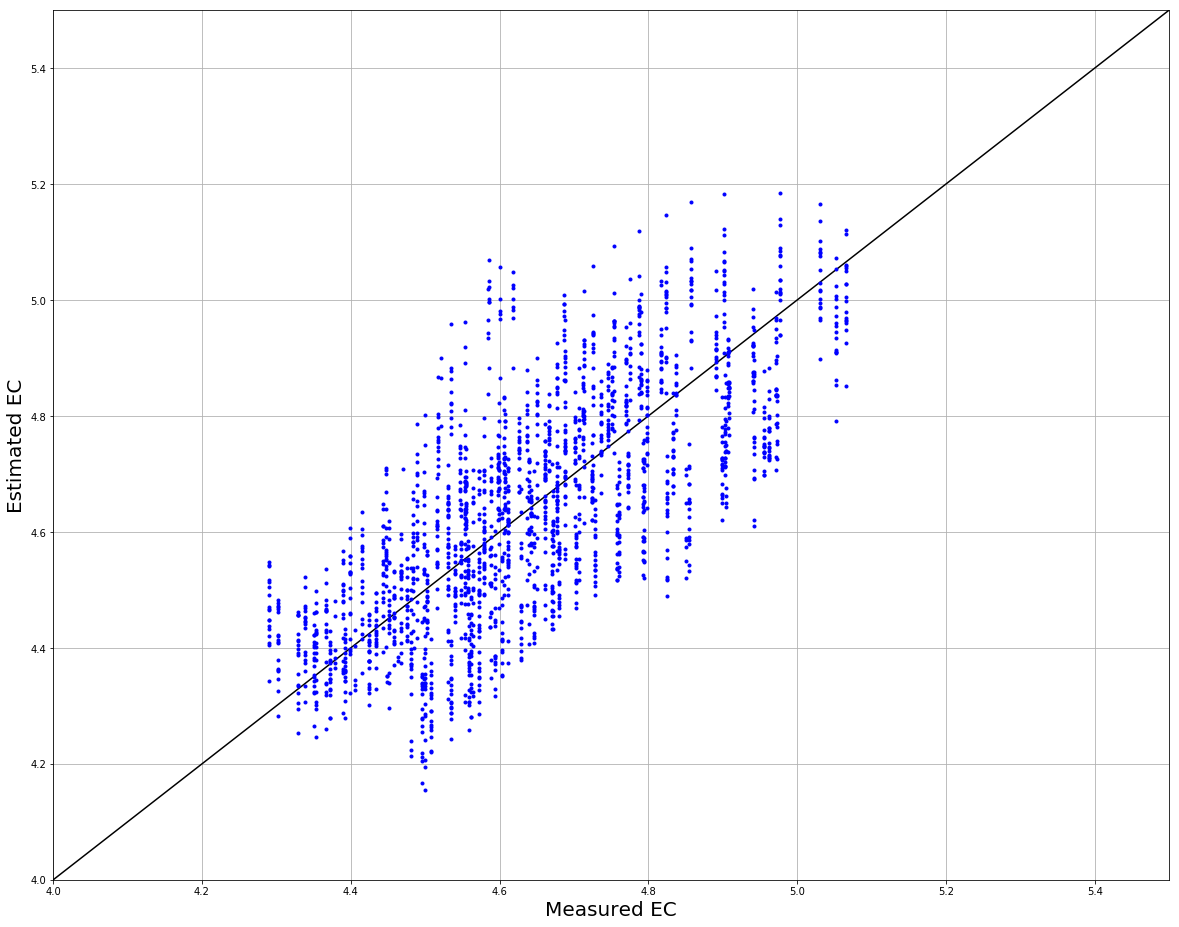

In [29]:
#1:1 graph
x_t = np.arange(-5, 15)
y_t = x_t

xny = plt.plot(x_t,y_t,'k')

expect1 = plt.plot(pred_label, prediction, 'b.')

plt.axis([4, 5.5, 4, 5.5])
plt.grid(True)
plt.xlabel('Measured EC', {'fontsize':20})
plt.ylabel('Estimated EC',  {'fontsize':20})
#plt.legend([expect1], ["Mg"], prop={'size': 12})
plt.show()

1 0.0853368677521
2 0.0922053654671
3 0.10965363926
4 0.104029073228
5 0.0940966979126
6 0.113117443687
7 0.0958219649082
8 0.106012362844
9 0.117218827932
10 0.1033025989
11 0.111702636664
12 0.110275801677
13 0.116613146639
14 0.119591190566
15 0.122602495646
16 0.1447182001
17 0.140456255324
18 0.14045891944
[0.085336867752075232, 0.092205365467071559, 0.10965363926004486, 0.10402907322777644, 0.094096697912569374, 0.11311744368659135, 0.095821964908176113, 0.10601236284397274, 0.1172188279321459, 0.10330259889955874, 0.11170263666364887, 0.11027580167699744, 0.11661314663922358, 0.11959119056560373, 0.12260249564559372, 0.14471820010008635, 0.14045625532432843, 0.1404589194403755]


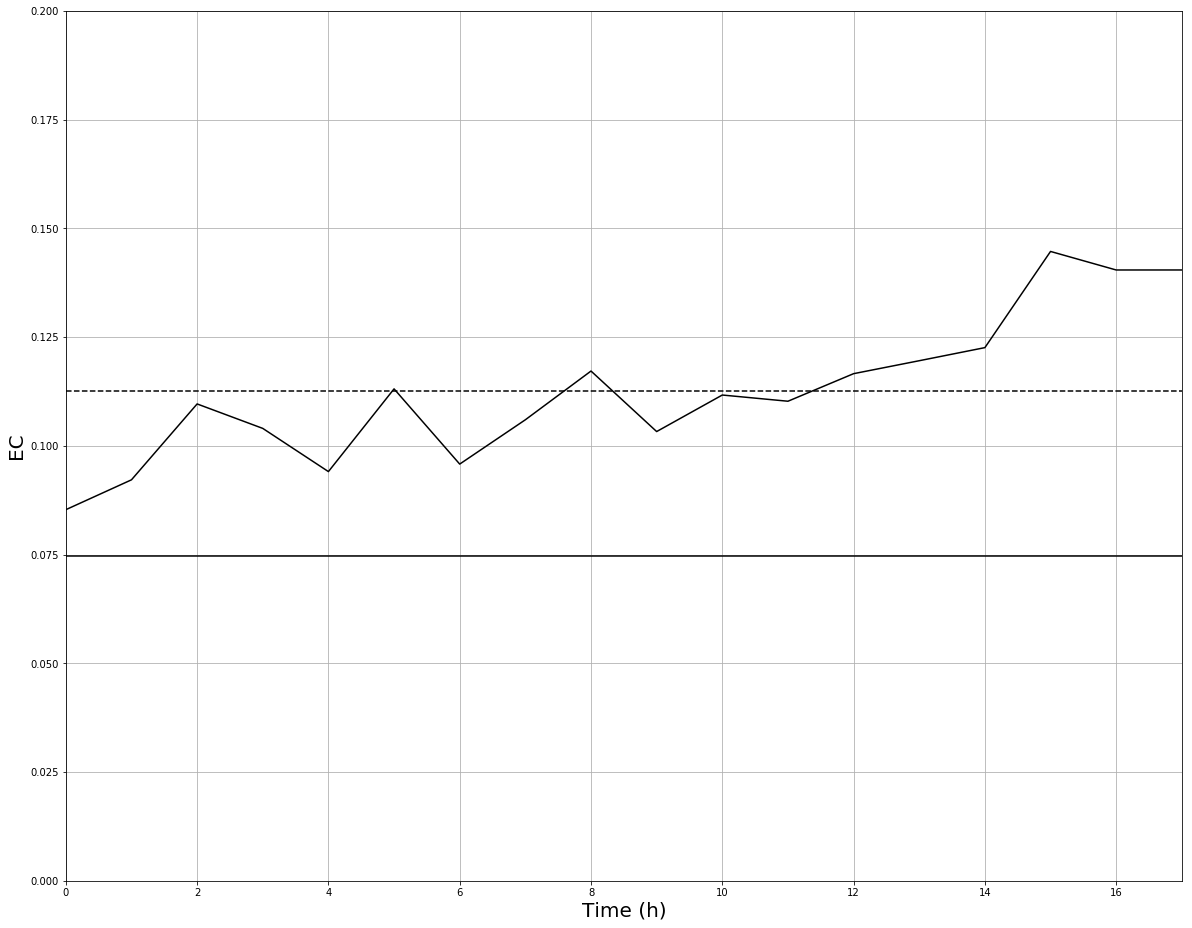

In [30]:
RMSE_data = []
for i in range(pred_label.shape[1]):
    k = np.sum(np.sqrt((pred_label[:, i] - prediction[:, i])**2))/120
    print(i+1, k)
    RMSE_data.append(k)
print(RMSE_data)


x_t = np.arange(0, 18)
y_t = x_t*0 + test_RMSE
y2_t = x_t*0 + valid_RMSE

RMSEs = plt.plot(x_t,RMSE_data, 'k')
test_RMSE = plt.plot(x_t, y_t, 'k--')
valid_RMSE = plt.plot(x_t, y2_t, 'k-')

plt.axis([0, 17, 0, 0.2])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

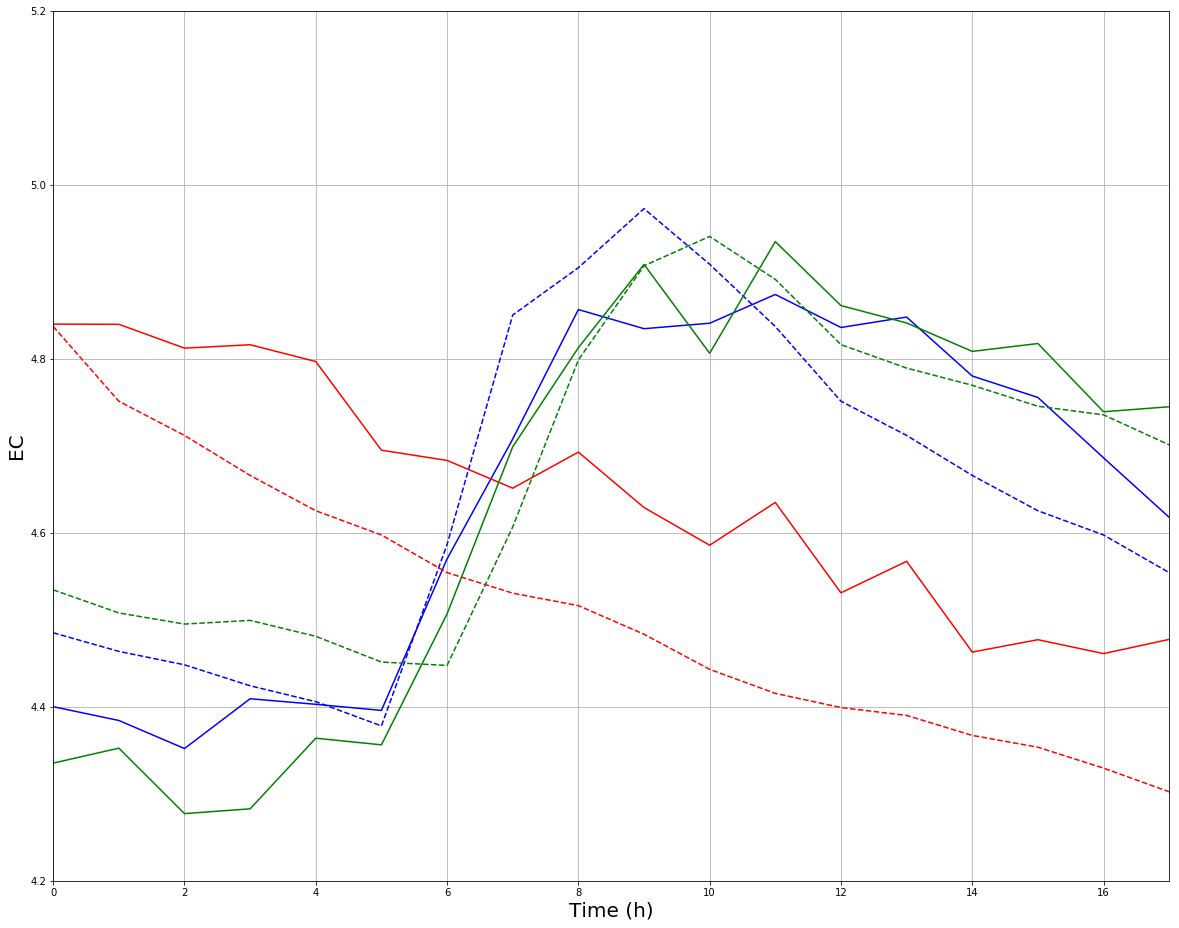

In [31]:
#chronological graph
i = 0
j = 11
k = 72
x_t = np.arange(0, 18)


expect1 = plt.plot(x_t, prediction[i,:].T, 'b') #estimated
measured1 = plt.plot(x_t, pred_label[i,:].T, 'b--') #estimated

expect2 = plt.plot(x_t, prediction[j,:].T, 'r') #estimated
measured2 = plt.plot(x_t, pred_label[j,:].T, 'r--') #estimated

expect3 = plt.plot(x_t, prediction[k,:].T, 'g') #estimated
measured3 = plt.plot(x_t, pred_label[k,:].T, 'g--') #estimated


plt.axis([0, 17, 4.2, 5.2])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

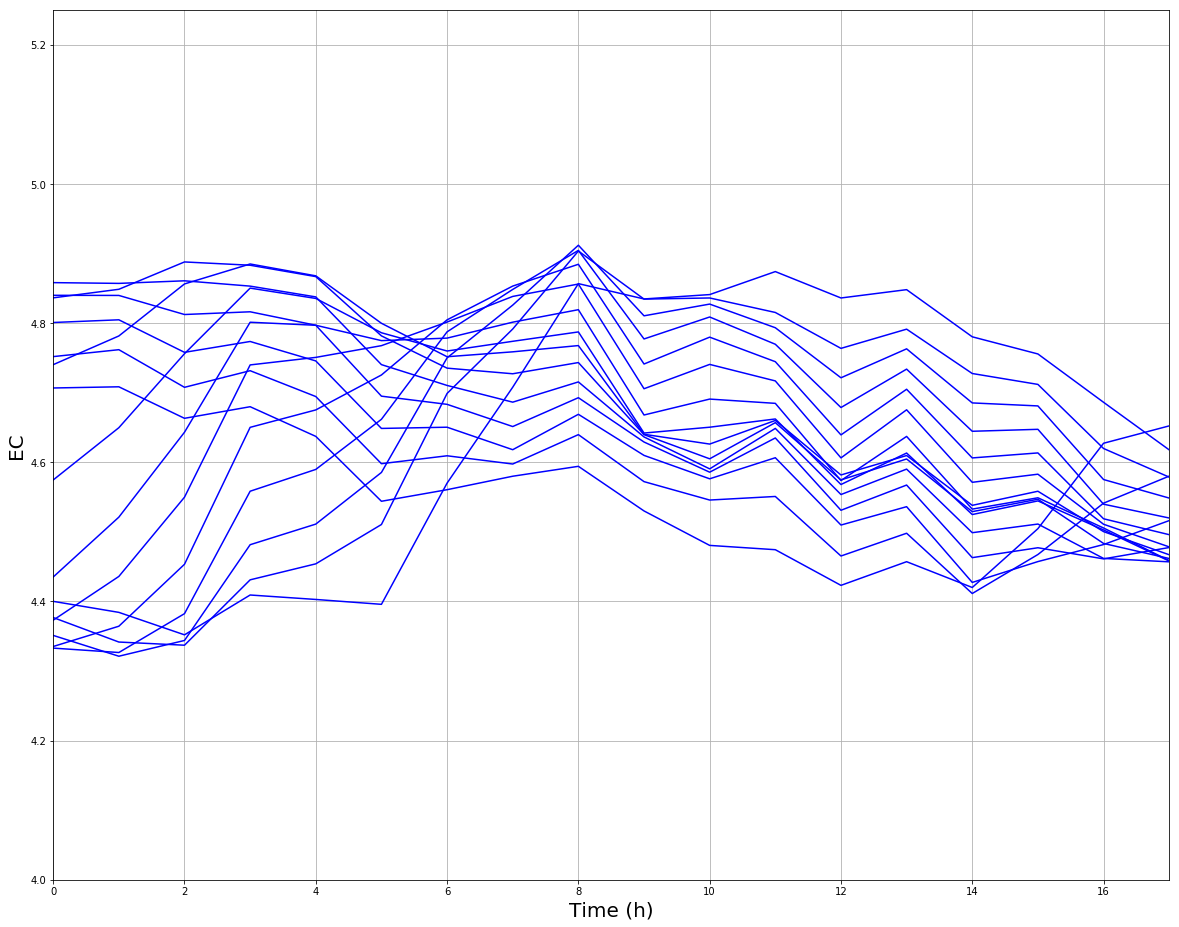

In [32]:
#chronological graph
x_t = np.arange(0, 18)

#measured1 = plt.plot(x_t, pred_label[:,:].T, 'k') #estimated
expect1 = plt.plot(x_t, prediction[:15,:].T, 'b') #estimated

plt.axis([0, 17, 4, 5.25])
plt.grid(True)
plt.xlabel('Time (h)', {'fontsize':20})
plt.ylabel('EC',  {'fontsize':20})
plt.show()

In [33]:
regression_output = np.concatenate((pred_label.T, prediction.T), axis=0).T

file_name = "pred_output_" + explanation + ".CSV"
np.savetxt("./Results/" + file_name, regression_output, delimiter=",")

In [34]:
sess.close()